In [25]:
from datetime import datetime, timezone, timedelta
from argopy import DataFetcher, ArgoNVSReferenceTables, ArgoIndex
import argopy, os
from sqlalchemy import create_engine, and_, func, UniqueConstraint
from geoalchemy2 import Geometry
from sqlalchemy.orm import declarative_base, sessionmaker, scoped_session, relationship
from sqlalchemy.orm.exc import NoResultFound
from sqlalchemy.pool import NullPool
from sqlalchemy.dialects.postgresql import insert, JSONB
from sqlalchemy import Index, Column, Integer, Float, DateTime, String, TEXT, TIMESTAMP, inspect, ForeignKey, JSON
from geoalchemy2 import WKTElement, Geometry
from geoalchemy2.shape import from_shape
from shapely.geometry import LineString
import pandas as pd
import geojson
from argopy.plot import scatter_map, scatter_plot #only needed to plot  

In [2]:
# Get the directory of your current script
current_dir = os.path.abspath(os.path.dirname("__file__"))

# Define the path to the tmp_cache directory relative to your current script
cache_dir = os.path.join(current_dir, '..', 'argo', 'tmp_cache')
print(cache_dir)

# Create the cache directory if it doesn't exist
os.makedirs(cache_dir, exist_ok=True)

# Set argopy options with the correct path
argopy.set_options(cachedir=cache_dir)


/home/bioer/python/argo/dev/../argo/tmp_cache


In [3]:
import os
from urllib.parse import quote 
from dotenv import load_dotenv

load_dotenv()
DBUSER = os.getenv('DBUSER')
DBPASS = os.getenv('DBPASS')
DBHOST = os.getenv('DBHOST')
DBPORT = os.getenv('DBPORT')
DBNAME = os.getenv('DBNAME')
WMOTABLE = os.getenv('WMOTABLE')
ARGOTABLE = os.getenv('ARGOTABLE')
TRAJTABLE = os.getenv('TRAJTABLE')

In [4]:
# Connect to the PostGIS database
conn_uri = 'postgresql://' + DBUSER + ':%s@' + DBHOST + ':' + DBPORT + '/' + DBNAME

# Create the SQLAlchemy engine with increased timeout and connection pooling
engine = create_engine(
    conn_uri % quote(DBPASS),
    connect_args={'connect_timeout': 10},  # Set a higher timeout
    pool_pre_ping=True,  # Enable pre-pinging to avoid broken connections
    poolclass=NullPool    # Optional: Use NullPool if you want to avoid pooling, or adjust as needed
)

In [17]:
reftbl = ArgoNVSReferenceTables().tbl('R03')
oceantbl = ArgoNVSReferenceTables().tbl('R13')

In [41]:
param_list = reftbl['altLabel'].tolist()
print(param_list)

['BBP', 'BBP470', 'BBP532', 'BBP700', 'BETA_BACKSCATTERING', 'BETA_BACKSCATTERING470', 'BETA_BACKSCATTERING532', 'BETA_BACKSCATTERING700', 'BISULFIDE', 'BPHASE_DOXY', 'C1PHASE_DOXY', 'C2PHASE_DOXY', 'CDOM', 'CHLA', 'CHLA_FLUORESCENCE', 'CNDC', 'COUNT_DOXY', 'CP', 'CP660', 'DOWNWELLING_PAR', 'DOWN_IRRADIANCE', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE412', 'DOWN_IRRADIANCE443', 'DOWN_IRRADIANCE490', 'DOWN_IRRADIANCE555', 'DOXY', 'DPHASE_DOXY', 'FIT_ERROR_NITRATE', 'FLUORESCENCE_CDOM', 'FLUORESCENCE_CHLA', 'FREQUENCY_DOXY', 'HUMIDITY_NITRATE', 'IB_PH', 'IK_PH', 'LED_FLASHING_COUNT_DOXY', 'MLPL_DOXY', 'MOLAR_DOXY', 'MOLAR_NITRATE', 'MTIME', 'NB_SAMPLE', 'NB_SAMPLE_CROVER', 'NB_SAMPLE_CTD', 'NB_SAMPLE_CYC', 'NB_SAMPLE_DURAFET', 'NB_SAMPLE_ECO', 'NB_SAMPLE_ISUS', 'NB_SAMPLE_MCOMS', 'NB_SAMPLE_OCR', 'NB_SAMPLE_OPTODE', 'NB_SAMPLE_STM', 'NB_SAMPLE_SUNA', 'NITRATE', 'PHASE_DELAY_DOXY', 'PH_IN_SITU_FREE', 'PH_IN_SITU_SEAWATER', 'PH_IN_SITU_TOTAL', 'PPOX_DOXY', 'PRES', 'PSAL', 'RAW_DOWNWELLING_IRRA

In [18]:
print(oceantbl)

  altLabel            prefLabel  \
0        A  Atlantic ocean area   
1        I    Indian ocean area   
2        P   Pacific ocean area   

                                          definition deprecated  \
0  The Atlantic/Pacific oceans boundary is at 70 ...      false   
1  The Indian/Atlantic oceans boundary is at 20 d...      false   
2  The Pacific/Indian oceans boundary is at 145 d...      false   

                                                  id  
0  http://vocab.nerc.ac.uk/collection/R13/current/A/  
1  http://vocab.nerc.ac.uk/collection/R13/current/I/  
2  http://vocab.nerc.ac.uk/collection/R13/current/P/  


In [5]:
sidx = ArgoIndex(index_file='bgc-s').load() 
sidx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
Loaded: True (312613 records)
Searched: False

In [49]:
dfs = sidx.to_dataframe()

In [7]:
print(dfs)

                                           file                date  latitude  \
0        aoml/1900722/profiles/SD1900722_001.nc 2006-10-22 02:16:24   -40.316   
1        aoml/1900722/profiles/SD1900722_002.nc 2006-11-01 06:44:23   -40.390   
2        aoml/1900722/profiles/SD1900722_003.nc 2006-11-11 10:12:22   -40.455   
3        aoml/1900722/profiles/SD1900722_004.nc 2006-11-21 07:50:21   -40.134   
4        aoml/1900722/profiles/SD1900722_005.nc 2006-12-01 18:33:00   -39.641   
...                                         ...                 ...       ...   
312608  meds/4902686/profiles/SR4902686_006D.nc 2024-05-18 16:38:00       NaN   
312609   meds/4902686/profiles/SR4902686_007.nc 2024-05-20 15:38:00    56.919   
312610  meds/4902686/profiles/SR4902686_007D.nc 2024-05-19 16:13:00       NaN   
312611   meds/4902686/profiles/SR4902686_008.nc 2024-05-21 15:40:00    56.951   
312612  meds/4902686/profiles/SR4902686_008D.nc 2024-05-20 16:22:00       NaN   

        longitude ocean  pr

In [50]:
dfs = dfs.dropna(subset = ['longitude', 'latitude', 'date', 'parameters', 'parameter_data_mode'])
print(len(dfs))

310040


In [51]:
dfs_sorted = dfs.sort_values(by='date_update', ascending=False)
dfs_unique = dfs_sorted.drop_duplicates(subset=['wmo', 'cyc', 'parameters', 'date'], keep='first')
print(dfs_unique.head())
print(len(dfs_unique))

                                              file                date  \
266740     csiro/5905556/profiles/SR5905556_058.nc 2024-05-25 04:43:00   
119044  coriolis/1902593/profiles/SR1902593_051.nc 2024-05-25 06:15:51   
111605      bodc/3902491/profiles/SR3902491_071.nc 2024-05-24 12:12:00   
243780      csio/2902882/profiles/SR2902882_134.nc 2024-05-25 02:06:20   
243099      csio/2902835/profiles/SR2902835_090.nc 2024-05-25 05:36:34   

        latitude  longitude ocean  profiler_code institution_code  \
266740   -57.855    159.158     P            836               CS   
119044   -52.214     94.310     I            834               IF   
111605    36.788    -72.250     A            836               BO   
243780    22.395    144.720     P            841               HZ   
243099   -44.481    -48.640     A            841               HZ   

                                               parameters parameter_data_mode  \
266740  PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...  

In [10]:
# Check again for duplicates to ensure the process was successful
assert not dfs_unique.duplicated(subset=['wmo', 'cyc', 'parameters', 'date']).any(), "Duplicates remain after processing!"


(<Figure size 900x540 with 1 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>)

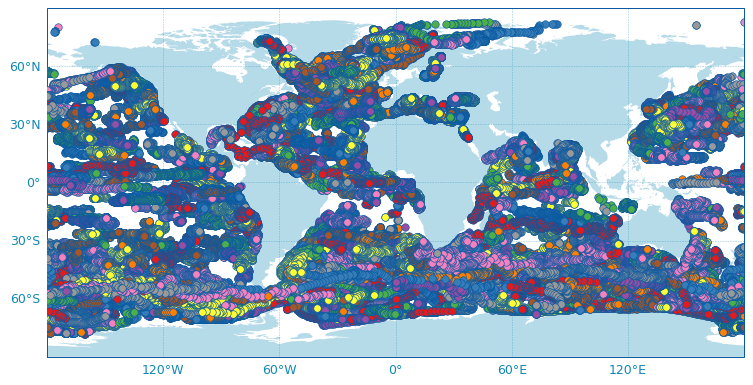

In [89]:
scatter_map(dfs_unique, traj=False, set_global=False, legend=False)

In [11]:
def expand_parameters(row):
    parameters = row['parameters'].split()
    modes = list(row['parameter_data_mode'])
    rows = {
        'parameter': parameters,
        'data_mode': [modes[i] for i in range(len(parameters)) if parameters[i] in parameters]
    }
    
    # Include all other columns
    for col in row.index.difference(['parameters', 'parameter_data_mode']):
        rows[col] = [row[col] for _ in parameters]
    
    return pd.DataFrame(rows)

In [12]:
# Apply the function and concatenate the results
expanded_df = pd.concat([expand_parameters(row) for index, row in dfs_unique.iterrows()]).reset_index(drop=True)

print(expanded_df)

                  parameter data_mode  cyc                date  \
0                      PRES         A   58 2024-05-25 04:43:00   
1                      TEMP         A   58 2024-05-25 04:43:00   
2                      PSAL         A   58 2024-05-25 04:43:00   
3                      DOXY         A   58 2024-05-25 04:43:00   
4        DOWN_IRRADIANCE380         R   58 2024-05-25 04:43:00   
...                     ...       ...  ...                 ...   
1999020                DOXY         R    1 2019-05-30 16:50:46   
1999021                PRES         R    1 2019-05-28 16:57:00   
1999022                TEMP         R    1 2019-05-28 16:57:00   
1999023                PSAL         R    1 2019-05-28 16:57:00   
1999024                DOXY         R    1 2019-05-28 16:57:00   

                date_update                                        file  \
0       2024-05-25 09:21:29     csiro/5905556/profiles/SR5905556_058.nc   
1       2024-05-25 09:21:29     csiro/5905556/profiles/SR

In [13]:
# Check for duplicates in the specified columns
duplicates = expanded_df.duplicated(subset=['wmo', 'cyc', 'parameter', 'date'], keep=False)

# Print out duplicates
print("Duplicates found:\n", expanded_df[duplicates].sort_values(['wmo', 'cyc', 'parameter']))


Duplicates found:
 Empty DataFrame
Columns: [parameter, data_mode, cyc, date, date_update, file, institution, institution_code, latitude, longitude, ocean, profiler, profiler_code, wmo]
Index: []


In [48]:
test = expanded_df[(expanded_df['wmo'] == 1900722) & 
                   (expanded_df['parameter'] == 'PRES')]
print(test)

        parameter data_mode  cyc                date         date_update  \
1983457      PRES         D  135 2010-07-15 11:19:48 2022-06-28 08:36:49   
1983461      PRES         D  134 2010-07-05 06:41:50 2022-06-28 08:36:37   
1983465      PRES         D  133 2010-06-25 02:22:31 2022-06-28 08:36:24   
1983469      PRES         D  132 2010-06-15 01:08:33 2022-06-28 08:36:11   
1983473      PRES         D  131 2010-06-04 18:20:34 2022-06-28 08:35:59   
...           ...       ...  ...                 ...                 ...   
1983977      PRES         D    5 2006-12-01 18:33:00 2022-06-28 08:08:52   
1983981      PRES         D    4 2006-11-21 07:50:21 2022-06-28 08:08:39   
1983985      PRES         D    3 2006-11-11 10:12:22 2022-06-28 08:08:26   
1983989      PRES         D    2 2006-11-01 06:44:23 2022-06-28 08:08:13   
1983993      PRES         D    1 2006-10-22 02:16:24 2022-06-28 08:08:01   

                                           file institution institution_code  \
1983457

In [14]:
dfo = expanded_df.drop('file', axis=1)

In [61]:
df_w = dfs_unique.drop('file', axis=1)
df_w.sort_values(by='date', inplace=True)
print(df_w)

                      date  latitude  longitude ocean  profiler_code  \
9750   2002-09-08 23:02:52    22.882   -157.987     P            846   
9751   2002-09-19 12:00:42    22.910   -157.812     P            846   
9752   2002-09-30 01:30:01    22.887   -157.416     P            846   
9753   2002-10-10 14:18:32    22.803   -157.025     P            846   
9754   2002-10-21 03:05:10    22.736   -156.831     P            846   
...                    ...       ...        ...   ...            ...   
242559 2024-05-25 05:38:13   -38.535    -51.057     A            841   
242469 2024-05-25 05:40:05   -44.383     -6.493     A            841   
242919 2024-05-25 05:41:23   -49.006      4.883     A            841   
242739 2024-05-25 06:04:49   -45.965    -15.992     A            841   
119044 2024-05-25 06:15:51   -52.214     94.310     I            834   

       institution_code                                         parameters  \
9750                 AO                                PR

In [69]:
Base = declarative_base()
class ArgoWMO(Base):
    __tablename__ = WMOTABLE
    wmo = Column(Integer, primary_key=True)
    ocean = Column(TEXT)
    profiler = Column(TEXT)
    #profiler_code = Column(Integer)
    institution = Column(TEXT)
    #institution_code = Column(TEXT)
    # Relationships
    floats = relationship("ArgoFloat", back_populates="wmo_info")
    trajectories = relationship("ArgoTrajectory", back_populates="wmo_info")


In [70]:
class ArgoTrajectory(Base):
    __tablename__ = TRAJTABLE
    #wmo = Column(Integer, primary_key=True)  
    wmo = Column(Integer, ForeignKey(WMOTABLE + '.wmo'), primary_key=True)
    start_date = Column(TIMESTAMP(timezone=True))
    end_date = Column(TIMESTAMP(timezone=True))
    lon_max = Column(Float)
    lon_min = Column(Float)
    lat_max = Column(Float)
    lat_min = Column(Float)
    parameters = Column(TEXT)  # space-separated list of unique parameters
    data_modes = Column(TEXT)  # space-separated list of unique data modes
    geojson = Column(JSONB)  # storing GeoJSON as JSONB for better performance
    geom = Column(Geometry(geometry_type='LINESTRING', srid=4326))  # storing trajectory as a PostGIS geometry
    # Relationship
    wmo_info = relationship("ArgoWMO", back_populates="trajectories")
    
# Example to create and bind engine (adjust connection string as needed)


In [71]:
# Base.metadata.create_all(engine)

In [72]:
#Base = declarative_base()
#print(Base)
# Define a model for your data
class ArgoFloat(Base):
    __tablename__ = ARGOTABLE  # Update the table name to match your actual table
    date = Column(TIMESTAMP(timezone=True), nullable=False, primary_key=True)
    latitude = Column(Float, nullable=False)
    longitude = Column(Float, nullable=False)
    #ocean = Column(TEXT)
    #profiler = Column(TEXT)
    #profiler_code = Column(Integer)
    #institution = Column(TEXT)
    #institution_code = Column(TEXT)
    date_update = Column(TIMESTAMP(timezone=True))
    #wmo = Column(Integer, nullable=False, primary_key=True)
    wmo = Column(Integer, ForeignKey(WMOTABLE + '.wmo'))
    cyc = Column(Integer, nullable=False, primary_key=True)
    parameter = Column(TEXT, nullable=False, primary_key=True)
    data_mode = Column(TEXT, nullable=False)
    geom = Column(Geometry(geometry_type='POINT', srid=4326))
    __table_args__ = (
        Index('argofloats_date_idx', 'date'),
        Index('argofloats_wmo_cyc_parameter_date_key', 'wmo', 'cyc', 'parameter', 'date', unique=True),
        Index('argofloats_wmo_cyc_parameter_date_idx', 'wmo', 'cyc', 'parameter', 'date'),
        Index('argofloats_date_parameter_idx', 'date', 'parameter'),
        Index('argofloats_date_data_mode_idx', 'date', 'data_mode'),
        Index('argofloats_geom_index', 'geom', postgresql_using='gist')
    )
    # Relationship
    wmo_info = relationship("ArgoWMO", back_populates="floats")

In [58]:
#floats = relationship("ArgoFloat", back_populates="wmo_info", primaryjoin="ArgoWMO.wmo == ArgoFloat.wmo")
#trajectories = relationship("ArgoTrajectory", primaryjoin="ArgoWMO.wmo==ArgoTrajectory.wmo", back_populates="wmo_info")
#floats

<_RelationshipDeclared at 0x7f7c1e335630; no key>

In [108]:
# Use Inspector to check if the table already exists
# Note create_all(self, bind=None, tables=None, checkfirst=True), and according to doc:
# Defaults to True, don't issue CREATEs for tables already present in the target database.
# inspector = inspect(engine)
# if not inspector.has_table(ARGOTABLE):  # Replace "argo_floats" with your table name
Base.metadata.create_all(engine)
print("Create table: ", Base)
# else:
# Table already exists, maybe print a message or perform other operations
# print("Table already exists. Skipping creation.", Base)
    

Create table:  <class 'sqlalchemy.orm.decl_api.Base'>


In [36]:
ocean_full_names = {
    'A': 'Atlantic Ocean Area',
    'I': 'Indian Ocean Area',
    'P': 'Pacific Ocean Area'
}

In [59]:
def convert_types(row):
    """Convert all numpy types in the row to native Python types."""
    for key in row.index:
        if type(row[key]).__module__ == 'numpy':  # Check if the type is a numpy type
            row[key] = row[key].item()  # Convert numpy types to Python scalar types
    return row

# Convert dataframe types before using them in the session
# df_w = df_w.apply(convert_types, axis=1)

In [60]:
def create_geojson_line(group):
    # Ensure there are at least two points
    if len(group) < 2:
        return None  # or handle it some other way that fits your application's logic
    
    points = [geojson.Point((lon, lat)) for lon, lat in zip(group['longitude'], group['latitude'])]
    properties = {
        'wmo': int(group['wmo'].iloc[0]),
        'timestamps': group['date'].apply(lambda x: x.isoformat()).tolist()
    }
    line = geojson.LineString([(point.coordinates[0], point.coordinates[1]) for point in points])
    feature = geojson.Feature(geometry=line, properties=properties)
    return geojson.dumps(feature)

In [73]:
# Write WMOTABLE and TRAJTALE table
Session = sessionmaker(bind=engine)
session = Session()

for wmo, group in df_w.groupby('wmo'):
    ocean_area = ocean_full_names.get(group['ocean'].iloc[0], '') #'' means unspecified/unknown
    argo_wmo = ArgoWMO(
        wmo=wmo,
        ocean=ocean_area,
        profiler=group['profiler'].iloc[0],
        #profiler_code=int(group['profiler_code'].iloc[0]),
        institution=group['institution'].iloc[0],
        #institution_code=group['institution_code'].iloc[0]
    )
    session.add(argo_wmo)
    
    # Create trajectory data
    geojson_string = create_geojson_line(group)
    if geojson_string:
        line_geom = from_shape(LineString(list(zip(group['longitude'], group['latitude']))), srid=4326)
    else:
        line_geom = None  # Or some other default handling
    argo_trajectory = ArgoTrajectory(
        wmo=wmo,
        start_date=group['date'].min(),
        end_date=group['date'].max(),
        lon_max=group['longitude'].max(),
        lon_min=group['longitude'].min(),
        lat_max=group['latitude'].max(),
        lat_min=group['latitude'].min(),
        parameters=' '.join(set(' '.join(group['parameters']).split())),
        data_modes=' '.join(sorted(set(group['parameter_data_mode'].iloc[0]))),
        geojson=geojson_string,
        geom=line_geom
    )
    session.add(argo_trajectory)

session.commit()
session.close()

In [113]:
# Write ARGOTALE table
# Using bulk operations to reduce the number of individual transactions
Session = scoped_session(sessionmaker(bind=engine))

for index, row in dfo.iterrows():
    # Prepare the dictionary including the geom transformation
    data = row.to_dict()
    data['geom'] = WKTElement(f'POINT({row["longitude"]} {row["latitude"]})', srid=4326)

    # Create insert statement for the ArgoFloat data
    stmt = insert(ArgoFloat).values(**data)
    # Define the ON CONFLICT DO UPDATE behavior
    do_update_stmt = stmt.on_conflict_do_update(
        constraint='_wmo_cyc_parameter_date_uc',
        set_={k: v for k, v in data.items() if k != 'id'}
    )
    # Execute the statement
    Session.execute(do_update_stmt)

# Commit changes and close the session
Session.commit()
Session.close()

In [ ]:
# Update code (Not yet...)
# Update the past 7 days data into database
today = datetime.now(timezone.utc)
data_since_last_7days = today - timedelta(days=7)

# Define the region box [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
# Convert datetime objects to strings in a format that Pandas can understand
today_str = today.strftime('%Y-%m-%dT%H:%M:%SZ')  # ISO 8601 format
data_since_last_7days_str = data_since_last_7days.strftime('%Y-%m-%dT%H:%M:%SZ')

# Define the region box
BOX = [-180, 180, -90, 90, 0, 2000, data_since_last_7days_str, today_str]
print("Time duration: ", data_since_last_7days_str, today_str)


Time duration:  2024-05-16T02:40:29Z 2024-05-23T02:40:29Z


In [ ]:
# Fetch data
f = DataFetcher(ds='bgc', mode='expert', src='erddap', params='all',
            parallel=True, progress=True, cache=True,
            chunks_maxsize={'time': 10})
f = f.region(BOX).load()
idx = f.index


Final post-processing of the merged dataset () ...


/home/bioer/.pyenv/versions/3.11.3/envs/py311/lib/python3.11/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())


In [ ]:
df = idx
print(df)

                                       file                date  latitude  \
0    aoml/1902304/profiles/SR1902304_163.nc 2024-05-20 20:37:50    56.867   
1    aoml/1902369/profiles/SR1902369_018.nc 2024-05-20 06:31:16    45.145   
2    aoml/1902371/profiles/SR1902371_023.nc 2024-05-20 06:29:40    51.932   
3    aoml/1902380/profiles/SR1902380_086.nc 2024-05-16 15:26:21    18.567   
4    aoml/1902383/profiles/SR1902383_086.nc 2024-05-21 14:10:05    24.520   
..                                      ...                 ...       ...   
323  meds/4902686/profiles/SR4902686_004.nc 2024-05-17 15:40:00    56.391   
324  meds/4902686/profiles/SR4902686_005.nc 2024-05-18 15:42:00    56.583   
325  meds/4902686/profiles/SR4902686_006.nc 2024-05-19 15:38:00    56.808   
326  meds/4902686/profiles/SR4902686_007.nc 2024-05-20 15:38:00    56.919   
327  meds/4902686/profiles/SR4902686_008.nc 2024-05-21 15:40:00    56.951   

     longitude ocean  profiler_code institution_code  \
0      -20.015     

In [ ]:
print(df.columns.values.tolist())

['file', 'date', 'latitude', 'longitude', 'ocean', 'profiler_code', 'institution_code', 'parameters', 'parameter_data_mode', 'date_update', 'wmo', 'cyc', 'institution', 'profiler']


In [ ]:
# Define your database connection
session_factory = sessionmaker(bind=engine)
Session = scoped_session(session_factory)

# Update or insert data into the database
for index, row in expanded_df.iterrows():
    try:
        # Check if the float already exists
        existing = Session.query(ArgoFloat).filter(
            and_(
                ArgoFloat.wmo == row['wmo'],
                ArgoFloat.cyc == row['cyc'],
                ArgoFloat.parameter == row['parameter'],
                ArgoFloat.date == row['date'],
            )
        ).one()
        # Update existing record
        for key, value in row.items():
            setattr(existing, key, value)
        existing.geom = WKTElement(f'POINT({row["longitude"]} {row["latitude"]})', srid=4326)
    except NoResultFound:
        # Create new record if not exists
        new_float = ArgoFloat(**row.to_dict())
        new_float.geom = WKTElement(f'POINT({row["longitude"]} {row["latitude"]})', srid=4326)
        Session.add(new_float)

# Commit the changes
Session.commit()
Session.close()        